In [221]:
import os.path

import joblib
import mlflow
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    confusion_matrix,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
)
from warnings import filterwarnings

from sklearn.tree import DecisionTreeClassifier

filterwarnings("ignore")

### Understanding the business

It comes as no surprise that large marketing campaigns have negative sentiment amongst the general populace. Think about the last time you answered an unexpected phone call from an unknown number, if your experience is anything like my then, it was either a scam caller, telemarketer or survey taker. I find myself hanging up quickly when it comes to these types of calls, if I were to ever answer them. Every failed cold call costs the company commissioning the campaign time and money. The bank partner commissioning this study is seeking to increase campaign success and reduce costs by focusing on profiles that are more likely to accept their offerings. The bank partner would like a model that can better predict the type of person that would accept offers from our partner bank.

### Understanding the Features

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Understanding the Data


In [2]:
df = pd.read_csv("data/bank-additional-full.csv", sep=";")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [6]:
# Only 12 duplicates
print(
    f"Row count: {df.shape[0]}, Duplicate count: {df.shape[0] - df.drop_duplicates().shape[0]}"
)

Row count: 41188, Duplicate count: 12


In [7]:
# No columns missing data
df.isna().mean().round(2)

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

In [8]:
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15267,52,technician,married,professional.course,no,yes,no,cellular,jul,thu,...,4,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
16903,55,blue-collar,married,basic.6y,unknown,unknown,unknown,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
5388,33,admin.,married,high.school,no,no,no,telephone,may,fri,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
29924,42,blue-collar,divorced,basic.9y,no,no,no,cellular,apr,mon,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
32435,35,technician,married,high.school,unknown,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [9]:
y_counts = df["y"].value_counts()
fig = px.bar(
    y_counts,
    y="count",
    title="Those that say yes are in a minority class, suggesting an imbalanced dataset",
    labels={"count": "Count", "y": "Accepted Campaign"},
)
fig.show()
fig.write_image("images/acceptance_count.png")

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [10]:
fig = px.box(
    df,
    y="age",
    title="Most potential calls are towards people aged 32-47",
    labels={"age": "Age"},
)
fig.show()
fig.write_image("images/age_box.png")

In [11]:
# Store commonly used group by
by_y_df = df.groupby("y")
by_y_df.describe(include="object")

job                      marital                        education  \
     count unique     top  freq   count unique      top   freq     count   
y                                                                          
no   36548     12  admin.  9070   36548      4  married  22396     36548   
yes   4640     12  admin.  1352    4640      4  married   2532      4640   

            ... month        day_of_week                   poutcome         \
    unique  ...   top   freq       count unique  top  freq    count unique   
y           ...                                                              
no       8  ...   may  12883       36548      5  mon  7667    36548      3   
yes      8  ...   may    886        4640      5  thu  1045     4640      3   

                         
             top   freq  
y                        
no   nonexistent  32422  
yes  nonexistent   3141  

[2 rows x 40 columns]

In [25]:
# Ratio calculation, this should be a better metric to track over counts
age_ratio = (by_y_df["age"].value_counts() / df["age"].value_counts()).reset_index()
fig = px.bar(
    age_ratio.sort_values(by="count"),
    x="age",
    y="count",
    color="y",
    title="Older than 60 and younger than 23 gives at least a 20% success rate",
    labels={
        "age": "Age",
        "count": "Ratio accepting campaign",
        "y": "Accepted Campaign",
    },
)
fig.show()
fig.write_image("images/age_acceptance_ratio.png")

In [12]:
job_ratio = (by_y_df["job"].value_counts() / df["job"].value_counts()).reset_index()
fig = px.bar(
    job_ratio.sort_values(by="count"),
    x="job",
    y="count",
    color="y",
    title="Students and retirees are more likely to accept campaign",
    labels={
        "job": "Job",
        "count": "Ratio accepting campaign",
        "y": "Accepted Campaign",
    },
)
fig.show()
fig.write_image("images/job_acceptance_ratio.png")

In [13]:
education_ratio = (
    by_y_df["education"].value_counts() / df["education"].value_counts()
).reset_index()
fig = px.bar(
    education_ratio.sort_values(by="count"),
    x="education",
    y="count",
    color="y",
    title="People who are illiterate are more likely to accept campaign",
    labels={
        "education": "Education",
        "count": "Ratio accepting campaign",
        "y": "Accepted Campaign",
    },
)
fig.show()
fig.write_image("images/education_acceptance_ratio.png")

In [14]:
month_ratio = (
    by_y_df["month"].value_counts() / df["month"].value_counts()
).reset_index()
fig = px.bar(
    month_ratio.sort_values(by="count"),
    x="month",
    y="count",
    color="y",
    title="Month has a strong effect on acceptance",
    labels={
        "month": "Month",
        "count": "Ratio accepting campaign",
        "y": "Accepted Campaign",
    },
)
fig.show()
fig.write_image("images/month_acceptance_ratio.png")

In [15]:
fig = px.histogram(
    df,
    x="duration",
    color="y",
    title="The longer a call goes the higher the likelihood of acceptance",
    labels={"duration": "Duration", "y": "Accepted Campaign"},
)
fig.show()
fig.write_image("images/duration_acceptance_ratio.png")

In [16]:
fig = px.histogram(
    df,
    x="campaign",
    color="y",
    title="There are diminishing returns when making a call to the same person",
    labels={"campaign": "Number of calls", "y": "Accepted Campaign"},
)
fig.show()
fig.write_image("images/calls_acceptance_ratio.png")

In [54]:
fig = px.histogram(
    df[df["pdays"] != 999],
    x="pdays",
    color="y",
    title="Following up within a week increases the chance of success",
    labels={
        "pdays": "Days since last contact",
        "y": "Accepted Campaign",
        "count": "Count",
    },
)
fig.show()
fig.write_image("images/days_since_last_contact_acceptance_ratio.png")

In [41]:
# Correlation plots
corr_matrix = df.corr(numeric_only=True).round(2)
fig = px.imshow(
    corr_matrix,
    title="Unsurprisingly, social and economic attributes highly correlated",
    color_continuous_scale="RdBu_r",
    aspect="auto",
)
fig.update_layout(height=1000, width=1000, showlegend=False)
fig.show()
fig.write_image("images/correlation.png")

In [59]:
fig = px.histogram(
    by_y_df["cons.price.idx"].value_counts().reset_index(),
    x="cons.price.idx",
    y="count",
    color="y",
    title="Number of acceptors look static across consumer price index",
    labels={
        "cons.price.idx": "Consumer price index",
        "y": "Accepted Campaign",
        "count": "Count",
    },
)
fig.show()
fig.write_image("images/consumer_price_index_acceptance_ratio.png")

In [60]:
fig = px.histogram(
    by_y_df["cons.conf.idx"].value_counts().reset_index(),
    x="cons.conf.idx",
    y="count",
    color="y",
    title="Consumer confidence index may be used to improve acceptance",
    labels={
        "cons.conf.idx": "Consumer confidence index",
        "y": "Accepted Campaign",
        "count": "Count",
    },
)
fig.show()
fig.write_image("images/consumer_confidence_index_acceptance_ratio.png")

In [61]:
poutcome_ratio = (
    by_y_df["poutcome"].value_counts() / df["poutcome"].value_counts()
).reset_index()

fig = px.bar(
    poutcome_ratio,
    x="poutcome",
    y="count",
    color="y",
    title="Those that accept the previous campaign are more likely to accept the next campaign",
    labels={
        "poutcome": "Previous outcome",
        "y": "Accepted Campaign",
        "count": "Ratio accepting campaign",
    },
)
fig.update_layout(height=800, width=1000)
fig.show()
fig.write_image("images/poutcome_acceptance_ratio.png")

In [26]:
fig = px.scatter(
    df[df["duration"] != 0],
    x="duration",
    y="campaign",
    color="y",
    title="Number of calls does not correlate with duration of the call",
    labels={
        "campaign": "Number of calls",
        "duration": "Duration",
        "y": "Accepted Campaign",
    },
)
fig.show()
fig.write_image("images/calls_vs_duration.png")

### Understanding the data
The first thing that jumps out is how imbalanced the dataset is. This is to be expected considering that we are working with telemarketing data. I was also able to find some strong predictors for the accepting class. In particular, the following fields show strong promise: month, employment, number of contacts. It is also important to note that the pdays column using 999 to signify that fact the client was not priorly contacted. The author of this dataset also recommends avoiding the duration column as it highly affects the output.

### Data Preparation

In [64]:
# Remove outliers
q1 = df["age"].quantile(0.25)
q3 = df["age"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
df = df.query(f"age > 0 and age >= {lower_bound} and age <= {upper_bound}")

In [65]:
df.drop("duration", axis=1, inplace=True)

In [66]:
df.drop_duplicates(inplace=True)

In [78]:
# Enable MLflow's automatic experiment tracking for scikit-learn. This will help with tracking experiments
mlflow.sklearn.autolog()

In [79]:
# Make preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), make_column_selector(dtype_include=np.number)),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore"),
            make_column_selector(dtype_include=np.object_),
        ),
        (
            "poly",
            PolynomialFeatures(include_bias=False),
            make_column_selector(dtype_include=np.number),
        ),
    ]
)

In [80]:
# Split data
X = df.drop("y", axis=1)
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Models

In [89]:
def eval_model(pipe, model_name, key, X_train, X_test, y_train, y_test, best_params):
    yes = "yes"
    train_accuracy = accuracy_score(pipe.predict(X_train), y_train)
    train_precision = precision_score(pipe.predict(X_train), y_train, pos_label=yes)
    train_recall = recall_score(pipe.predict(X_train), y_train, pos_label=yes)
    train_f1 = f1_score(pipe.predict(X_train), y_train, pos_label=yes)

    test_accuracy = accuracy_score(pipe.predict(X_test), y_test)
    test_precision = precision_score(pipe.predict(X_test), y_test, pos_label=yes)
    test_recall = recall_score(pipe.predict(X_test), y_test, pos_label=yes)
    test_f1 = f1_score(pipe.predict(X_test), y_test, pos_label=yes)

    return {
        "model_name": model_name,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_precision": train_precision,
        "test_precision": test_precision,
        "train_recall": train_recall,
        "test_recall": test_recall,
        "train_f1": train_f1,
        "test_f1": test_f1,
        "coef": (
            pipe.named_steps[key].coef_
            if hasattr(pipe, 'named_steps') and hasattr(pipe.named_steps[key], "coef_")
            else None
        ),
        "best_params": best_params,
    }

In [94]:
recall_scorer = make_scorer(recall_score, pos_label="yes")

In [97]:
scores = []

In [98]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

2025/08/10 13:58:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c5c5483b06140f9b5272aca198be4ff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


2025/08/10 14:13:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 283 runs will be omitted.


{'preprocessor__poly__degree': 3, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.3, 'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 4}


In [99]:
dummy_evaluation = eval_model(
    dummy_clf,
    "DummyClassifier",
    "dummy",
    X_train,
    X_test,
    y_train,
    y_test,
    {},
)
scores.append(dummy_evaluation)

In [100]:
tree_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("tree", DecisionTreeClassifier(random_state=42)),
    ]
)

params = {
    "smote__k_neighbors": [3, 5],
    "smote__sampling_strategy": [0.3, 0.5],
    "tree__criterion": ["gini", "entropy"],
    "tree__max_depth": [3, 4, 5],
    "tree__min_samples_split": [4, 5],
    "tree__min_samples_leaf": [3, 4, 5],
    "preprocessor__poly__degree": [2, 3],
}

grid_tree = GridSearchCV(tree_pipe, param_grid=params, scoring=recall_scorer, verbose=1)
grid_tree.fit(X_train, y_train)
print(grid_tree.best_params_)

['bank_marketing_decision_tree.pkl']

In [101]:
tree_evaluation = eval_model(
    grid_tree.best_estimator_,
    "DecisionTreeClassifier",
    "tree",
    X_train,
    X_test,
    y_train,
    y_test,
    grid_tree.best_params_,
)
scores.append(tree_evaluation)

2025/08/10 14:13:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '96df4411097b4493b0962287545d5714', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 144 candidates, totalling 720 fits


2025/08/10 14:35:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, 139 runs will be omitted.


{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'preprocessor__poly__degree': 2, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}


In [102]:
joblib.dump(grid_tree.best_estimator_, "bank_marketing_decision_tree.pkl")

In [103]:
lr_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("lr", LogisticRegression(random_state=42)),
    ]
)

params = {
    "smote__k_neighbors": [3, 5],
    "smote__sampling_strategy": [0.3, 0.5],
    "lr__penalty": ["l1", "l2", "elasticnet"],
    "lr__max_iter": [500, 1000],
    "lr__C": [0.01, 0.1, 1],
    "preprocessor__poly__degree": [2, 3],
}

grid_lr = GridSearchCV(lr_pipe, param_grid=params, scoring=recall_scorer, verbose=1)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

['bank_marketing_logistic_regression.pkl']

In [104]:
lr_evaluation = eval_model(
    grid_lr.best_estimator_,
    "LogisticRegression",
    "lr",
    X_train,
    X_test,
    y_train,
    y_test,
    grid_lr.best_params_,
)
scores.append(lr_evaluation)

2025/08/10 14:35:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e1a4e99213b84d678a1f2e130ba383b1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/08/10 14:36:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


{'knn__n_neighbors': 5, 'preprocessor__poly__degree': 2, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}


In [105]:
joblib.dump(grid_lr.best_estimator_, "bank_marketing_logistic_regression.pkl")

In [106]:
knn_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("knn", KNeighborsClassifier()),
    ]
)

params = {
    "smote__k_neighbors": [3, 5],
    "smote__sampling_strategy": [0.3, 0.5],
    "knn__n_neighbors": [3, 5],
    "preprocessor__poly__degree": [2, 3],
}

grid_knn = GridSearchCV(knn_pipe, param_grid=params, scoring=recall_scorer, verbose=1)
grid_knn.fit(X_train, y_train)
print(grid_knn.best_params_)

['bank_marketing_knn.pkl']

In [108]:
knn_evaluation = eval_model(
    grid_knn.best_estimator_,
    "KNeighborsClassifier",
    "knn",
    X_train,
    X_test,
    y_train,
    y_test,
    grid_knn.best_params_,
)
scores.append(knn_evaluation)

2025/08/10 15:26:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '989f278929f5460eb3fbf5936e92cdac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/08/10 17:52:14 INFO mlflow.sklearn.utils: Logging the 5 best runs, 19 runs will be omitted.


{'preprocessor__poly__degree': 2, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.3, 'svc__C': 0.1}


In [109]:
joblib.dump(grid_knn.best_estimator_, "bank_marketing_knn.pkl")

In [110]:
svc_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("svc", SVC(random_state=42)),
    ]
)

params = {
    "smote__k_neighbors": [3, 5],
    "smote__sampling_strategy": [0.3, 0.5],
    "svc__C": [0.01, 0.1, 1],
    "preprocessor__poly__degree": [2, 3],
}

grid_svc = GridSearchCV(svc_pipe, param_grid=params, scoring=recall_scorer, verbose=1)
grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)

['bank_marketing_svc.pkl']

In [111]:
svc_evaluation = eval_model(
    grid_svc.best_estimator_,
    "SVC",
    "svc",
    X_train,
    X_test,
    y_train,
    y_test,
    grid_svc.best_params_,
)
scores.append(svc_evaluation)

2025/08/10 17:53:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc7d699b368641709b790b71ffd53266', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


2025/08/10 19:15:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, 283 runs will be omitted.


{'forest__max_depth': 3, 'forest__min_samples_leaf': 3, 'forest__min_samples_split': 4, 'forest__n_estimators': 200, 'preprocessor__poly__degree': 3, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}


In [112]:
joblib.dump(grid_svc.best_estimator_, "bank_marketing_svc.pkl")

In [113]:
forest_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("forest", RandomForestClassifier(random_state=42)),
    ]
)

params = {
    "smote__k_neighbors": [3, 5],
    "smote__sampling_strategy": [0.3, 0.5],
    "forest__n_estimators": [100, 200],
    "forest__max_depth": [3, 4, 5],
    "forest__min_samples_split": [4, 5],
    "forest__min_samples_leaf": [3, 4, 5],
    "preprocessor__poly__degree": [2, 3],
}

grid_forest = GridSearchCV(
    forest_pipe, param_grid=params, scoring=recall_scorer, verbose=1
)
grid_forest.fit(X_train, y_train)
print(grid_forest.best_params_)

['bank_marketing_forest.pkl']

In [114]:
forest_evaluation = eval_model(
    grid_forest.best_estimator_,
    "RandomForestClassifier",
    "forest",
    X_train,
    X_test,
    y_train,
    y_test,
    grid_forest.best_params_,
)
scores.append(forest_evaluation)

In [ ]:
joblib.dump(grid_forest.best_estimator_, "bank_marketing_forest.pkl")

In [246]:
scores_df = pd.DataFrame(scores)
scores_df.to_csv("data/scores_df.csv")

### Evaluation

In [247]:
def load_scores_data():
    if os.path.exists("data/scores_df.csv"):
        return pd.read_csv("data/scores_df.csv")
    print("Scores csv doesn't exist, train and score models first")
    return None

In [117]:
# Numeric columns
numeric_columns = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]

# Non-numeric columns
category_columns = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]

In [126]:
def get_feature_names(grid):
    preprocessor = grid.best_estimator_.named_steps["preprocessor"]
    scaler_features = preprocessor.named_transformers_["scaler"].get_feature_names_out(
        numeric_columns
    )
    poly_features = preprocessor.named_transformers_["poly"].get_feature_names_out(
        numeric_columns
    )

    onehot_features = preprocessor.named_transformers_["onehot"].get_feature_names_out(
        category_columns
    )
    return np.concatenate(
        [
            scaler_features,
            poly_features,
            onehot_features,
        ]
    )

In [248]:
scores_df = load_scores_data()

In [249]:
fig = make_subplots(
    rows=4,
    cols=1,
    subplot_titles=(
        "Train vs Test Accuracy",
        "Train vs Test Precision",
        "Train vs Test Recall",
        "Train vs Test F1",
    ),
)
metrics = [
    ("train_accuracy", "test_accuracy"),
    ("train_precision", "test_precision"),
    ("train_recall", "test_recall"),
    ("train_f1", "test_f1"),
]


def title_case(word):
    word.replace("_", " ")
    return word.title()


for i, metric_tuple in enumerate(metrics):
    train_bar = go.Bar(
        x=scores_df["model_name"],
        y=scores_df[metric_tuple[0]],
        name=title_case(metric_tuple[0]),
    )
    fig.add_trace(train_bar, row=i + 1, col=1)
    test_bar = go.Bar(
        x=scores_df["model_name"],
        y=scores_df[metric_tuple[1]],
        name=title_case(metric_tuple[1]),
    )
    fig.add_trace(test_bar, row=i + 1, col=1)

fig.update_layout(
    title_text="Train vs Test Accuracy, Precision, Recall and F1",
    yaxis_title="Metric performance",
    height=1000,
    width=1800,
    showlegend=True,
    barmode="group",
    bargap=0.35,
)
fig.show()
fig.write_image("images/metric_comparison.png")

In [192]:
# Roc Curve Logistic Regression
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
    grid_lr, X_test, y_test, pos_label="yes", ax=ax, name="LogisticRegression"
)
RocCurveDisplay.from_estimator(
    grid_knn, X_test, y_test, pos_label="yes", ax=ax, name="KNN"
)
RocCurveDisplay.from_estimator(
    grid_tree, X_test, y_test, pos_label="yes", ax=ax, name="DecisionTree"
)
RocCurveDisplay.from_estimator(
    grid_svc, X_test, y_test, pos_label="yes", ax=ax, name="SVC"
)
RocCurveDisplay.from_estimator(
    grid_forest, X_test, y_test, pos_label="yes", ax=ax, name="RandomForest"
)

plt.grid()
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label="baseline")
ax.set_title("Roc Auc curve comparison")
plt.savefig("images/roc_curve_comparison.png")
plt.legend()
plt.show()

In [193]:
# Roc Curve Logistic Regression
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(
    grid_lr, X_test, y_test, pos_label="yes", ax=ax, name="LogisticRegression"
)
PrecisionRecallDisplay.from_estimator(
    grid_knn, X_test, y_test, pos_label="yes", ax=ax, name="KNN"
)
PrecisionRecallDisplay.from_estimator(
    grid_tree, X_test, y_test, pos_label="yes", ax=ax, name="DecisionTree"
)
PrecisionRecallDisplay.from_estimator(
    grid_svc, X_test, y_test, pos_label="yes", ax=ax, name="SVC"
)
PrecisionRecallDisplay.from_estimator(
    grid_forest, X_test, y_test, pos_label="yes", ax=ax, name="RandomForest"
)

plt.grid()
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label="baseline")
ax.set_title("Precision Recall curve comparison")
plt.savefig("images/pr_curve_comparison.png")
plt.legend()
plt.show()

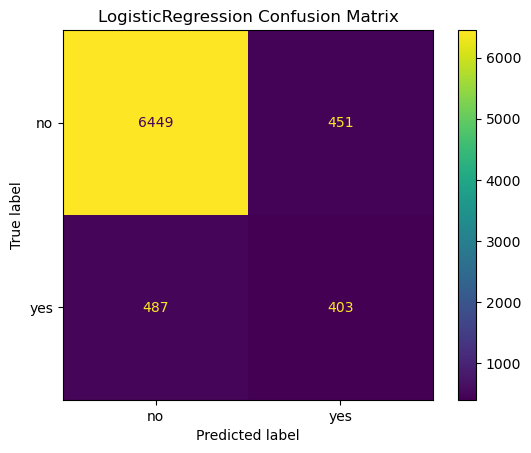

In [202]:
logistic_importance = {
    "Feature": get_feature_names(grid_lr),
    "Importance - Coef": np.abs(grid_lr.best_estimator_.named_steps["lr"].coef_[0]),
}
logistic_importance_df = pd.DataFrame(logistic_importance)

In [213]:
logistic_importance_df = logistic_importance_df.sort_values(
    "Importance - Coef", ascending=False
)
fig = px.bar(
    logistic_importance_df[:10],
    x="Importance - Coef",
    y="Feature",
    orientation="h",
    title="Top Ten Features LogisticRegression",
)
fig.show()
fig.write_image("images/logistic_regression_top_features.png")

In [214]:
# Logistic Regression confusion matrix
cm = confusion_matrix(y_test, grid_lr.best_estimator_.predict(X_test))
fig = ConfusionMatrixDisplay(cm, display_labels=grid_lr.best_estimator_.classes_)
fig.plot()
fig.ax_.set_title("LogisticRegression Confusion Matrix")
plt.savefig("images/logistic_regression_cm.png", dpi=100)
plt.show()

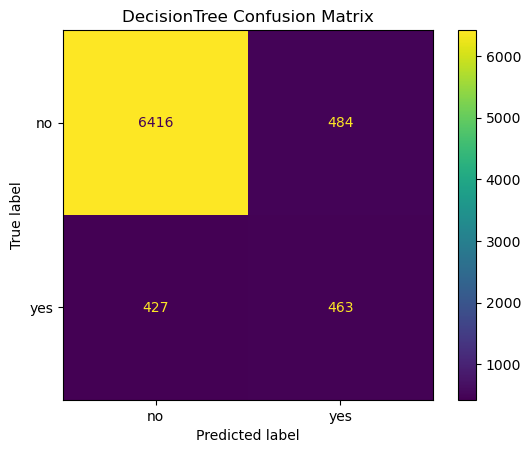

In [206]:
tree_importance = {
    "Feature": get_feature_names(grid_tree),
    "Importance": np.abs(
        grid_tree.best_estimator_.named_steps["tree"].feature_importances_
    ),
}
tree_importance_df = pd.DataFrame(tree_importance)

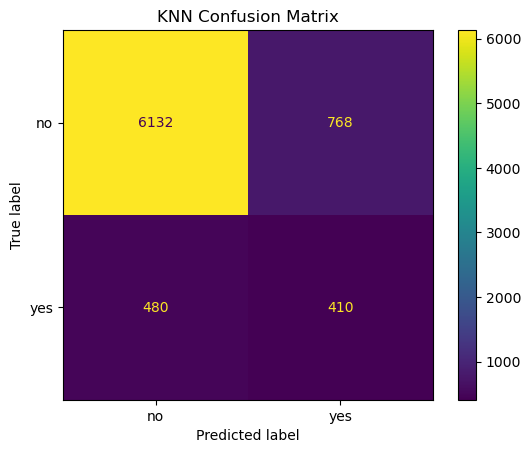

In [226]:
tree_importance_df = tree_importance_df.sort_values("Importance", ascending=False)
fig = px.bar(
    tree_importance_df[:10],
    x="Importance",
    y="Feature",
    orientation="h",
    title="Top Ten Features DecisionTree",
)
fig.show()
fig.write_image("images/decision_tree_top_features.png")

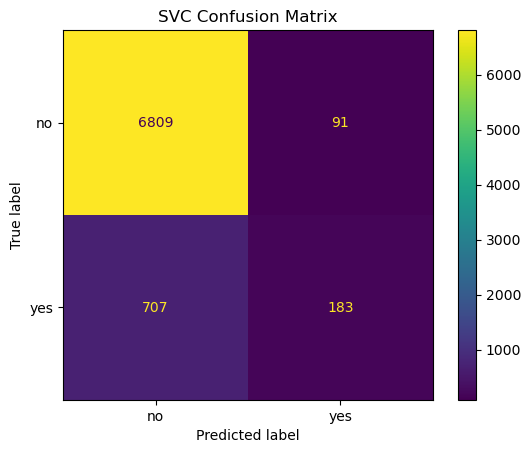

In [232]:
# DecisionTree confusion matrix
cm = confusion_matrix(y_test, grid_tree.best_estimator_.predict(X_test))
fig = ConfusionMatrixDisplay(cm, display_labels=grid_tree.best_estimator_.classes_)
fig.plot()
fig.ax_.set_title("DecisionTree Confusion Matrix")
plt.savefig("images/tree_cm.png", dpi=100)
plt.show()

In [236]:
# KNN confusion matrix
cm = confusion_matrix(y_test, grid_knn.best_estimator_.predict(X_test))
fig = ConfusionMatrixDisplay(cm, display_labels=grid_knn.best_estimator_.classes_)
fig.plot()
fig.ax_.set_title("KNN Confusion Matrix")
plt.savefig("images/knn_cm.png", dpi=100)
plt.show()

[0.00000000e+00 0.00000000e+00 1.76740750e-04 1.74275908e-04
 0.00000000e+00 7.02117044e-04 5.78342736e-03 1.75921413e-02
 2.69677444e-02 1.05459943e-03 6.66514715e-04 0.00000000e+00
 0.00000000e+00 1.26283578e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.62547217e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.61871305e-03 1.06595491e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.59293539e-04
 6.86864116e-04 0.00000000e+00 5.50429014e-05 1.94910259e-03
 0.00000000e+00 9.09496703e-04 9.95543680e-04 0.00000000e+00
 1.42437253e-03 0.00000000e+00 1.51942470e-03 6.53209742e-04
 0.00000000e+00 6.64049653e-04 5.17031011e-03 3.60829887e-03
 2.81277736e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.91135061e-05 1.63288335e-03 0.00000000e+00
 6.94935642e-04 0.00000000e+00 2.40716653e-04 2.78130395e-03
 1.24180460e-03 6.07548670e-04 1.18200951e-03 2.16126132e-03
 5.35636847e-04 1.32439856e-03 0.00000000e+00 1.45964649e-05
 7.54452913e-04 1.921652

In [234]:
# svc confusion matrix
cm = confusion_matrix(y_test, grid_svc.best_estimator_.predict(X_test))
fig = ConfusionMatrixDisplay(cm, display_labels=grid_svc.best_estimator_.classes_)
fig.plot()
fig.ax_.set_title("SVC Confusion Matrix")
plt.savefig("images/svc_cm.png", dpi=100)
plt.show()

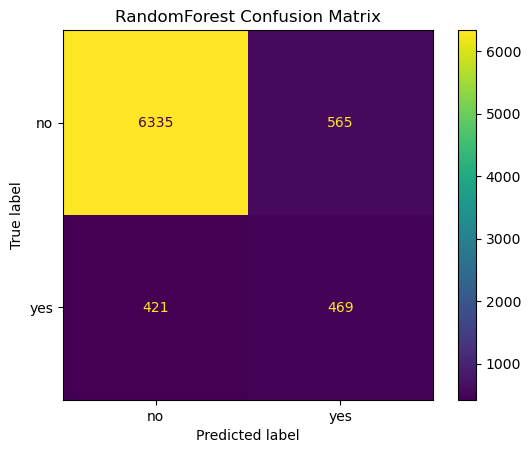

In [237]:
forest_importance = {
    "Feature": get_feature_names(grid_forest),
    "Importance": np.abs(
        grid_forest.best_estimator_.named_steps["forest"].feature_importances_
    ),
}
forest_importance_df = pd.DataFrame(forest_importance)

In [ ]:
forest_importance_df = forest_importance_df.sort_values("Importance", ascending=False)
fig = px.bar(
    forest_importance_df[:10],
    x="Importance",
    y="Feature",
    orientation="h",
    title="Top Ten Features RandomForest",
)
fig.show()
fig.write_image("images/forest_top_features.png")

In [ ]:
# RandomForest confusion matrix
cm = confusion_matrix(y_test, grid_forest.best_estimator_.predict(X_test))
fig = ConfusionMatrixDisplay(cm, display_labels=grid_forest.best_estimator_.classes_)
fig.plot()
fig.ax_.set_title("RandomForest Confusion Matrix")
plt.savefig("images/forest_cm.png", dpi=100)
plt.show()